# VAE for Music Clustering - Easy Task (Kaggle Version)
## Unsupervised Learning Project: Variational Autoencoder for Music Genre Clustering

**This version uses Kaggle for fast, reliable dataset download!**

This notebook implements:
- Basic VAE for feature extraction from music data
- K-Means clustering on latent features
- Visualization using t-SNE and UMAP
- Comparison with PCA + K-Means baseline
- Evaluation using Silhouette Score and Calinski-Harabasz Index

## 🔑 IMPORTANT: Kaggle API Setup

Before running this notebook, you need to get your Kaggle API key:

### Steps:
1. Go to https://www.kaggle.com
2. Sign in (or create a free account)
3. Click on your profile picture (top right) → Account
4. Scroll down to "API" section
5. Click "Create New API Token"
6. This downloads `kaggle.json` file
7. Upload `kaggle.json` to Colab using the file upload in the next cell

**Note**: The dataset download will be MUCH faster (2-3 minutes instead of 30+ minutes)!

## 1. Setup and Installation

In [1]:
# Check if GPU is available
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available:  []
TensorFlow version: 2.19.0


In [2]:
# Install required packages
!pip install -q librosa
!pip install -q umap-learn
!pip install -q scikit-learn
!pip install -q matplotlib seaborn
!pip install -q tensorflow
!pip install -q kaggle

## 2. Upload Kaggle API Key

Run this cell and upload your `kaggle.json` file when prompted.

In [3]:
from google.colab import files

print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle API key configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✅ Kaggle API key configured successfully!


## 3. Download GTZAN Dataset from Kaggle

This will download from Kaggle's servers (much faster and more reliable!).

In [4]:
import os

print("Downloading GTZAN dataset from Kaggle...")
print("This will take 2-3 minutes.\n")

# Download dataset
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

print("\nExtracting dataset...")
!unzip -q gtzan-dataset-music-genre-classification.zip

# Move to expected location
!mv Data/genres_original genres

# Clean up
!rm gtzan-dataset-music-genre-classification.zip
!rm -rf Data

print("\n✅ Dataset downloaded and extracted successfully!")
print(f"Dataset location: {os.path.abspath('genres')}")

This will take 2-3 minutes.

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [00:08<00:00, 137MB/s]
100% 1.21G/1.21G [00:08<00:00, 158MB/s]

Extracting dataset...

✅ Dataset downloaded and extracted successfully!
Dataset location: /content/genres


In [5]:
# Verify dataset structure
!ls -lh genres/
print("\nSample files in blues genre:")
!ls genres/blues/ | head -5

total 40K
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 blues
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 classical
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 country
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 disco
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 hiphop
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 jazz
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 metal
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 pop
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 reggae
drwxr-xr-x 2 root root 4.0K Jan 12 07:22 rock

Sample files in blues genre:
blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav


## 4. Import Libraries

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Visualization
import umap

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 5. Dataset Configuration

In [7]:
# Dataset configuration
DATA_PATH = 'genres'
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Audio processing parameters
SAMPLE_RATE = 22050
DURATION = 30  # seconds
N_MFCC = 20    # Number of MFCC features
HOP_LENGTH = 512

print(f"Genres: {GENRES}")
print(f"Total genres: {len(GENRES)}")

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total genres: 10


## 6. Feature Extraction (MFCC)

In [8]:
def extract_mfcc_features(file_path, n_mfcc=20, max_len=1293):
    """
    Extract MFCC features from audio file.

    Args:
        file_path: Path to audio file
        n_mfcc: Number of MFCC coefficients
        max_len: Maximum length of MFCC sequence

    Returns:
        mfcc: MFCC features of shape (n_mfcc, max_len)
    """
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=HOP_LENGTH)

        # Pad or truncate to max_len
        if mfcc.shape[1] < max_len:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [9]:
# Load and process all audio files
features_list = []
labels_list = []
file_paths = []

print("Extracting MFCC features from audio files...")
print("This will take approximately 8-12 minutes for 1000 songs.\n")

from tqdm import tqdm

for genre_idx, genre in enumerate(GENRES):
    genre_path = os.path.join(DATA_PATH, genre)
    if not os.path.exists(genre_path):
        print(f"Warning: {genre_path} not found, skipping...")
        continue

    audio_files = [f for f in os.listdir(genre_path) if f.endswith('.wav') or f.endswith('.au')]
    print(f"Processing {genre}: {len(audio_files)} files")

    for audio_file in tqdm(audio_files, desc=f"  {genre}"):
        file_path = os.path.join(genre_path, audio_file)
        mfcc = extract_mfcc_features(file_path, n_mfcc=N_MFCC)

        if mfcc is not None:
            features_list.append(mfcc)
            labels_list.append(genre_idx)
            file_paths.append(file_path)

# Convert to numpy arrays
X = np.array(features_list)  # Shape: (n_samples, n_mfcc, time_steps)
y = np.array(labels_list)     # Shape: (n_samples,)

print(f"\n✅ Feature extraction completed!")
print(f"Total samples loaded: {len(X)}")
print(f"Feature shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Extracting MFCC features from audio files...
This will take approximately 8-12 minutes for 1000 songs.

Processing blues: 100 files


  blues: 100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Processing classical: 100 files


  classical: 100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


Processing country: 100 files


  country: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


Processing disco: 100 files


  disco: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


Processing hiphop: 100 files


  hiphop: 100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


Processing jazz: 100 files


  jazz:  30%|███       | 30/100 [00:01<00:05, 12.83it/s]

Error processing genres/jazz/jazz.00054.wav: 


  jazz: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


Processing metal: 100 files


  metal: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


Processing pop: 100 files


  pop: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


Processing reggae: 100 files


  reggae: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


Processing rock: 100 files


  rock: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


✅ Feature extraction completed!
Total samples loaded: 999
Feature shape: (999, 20, 1293)
Labels shape: (999,)


In [10]:
# Normalize features
X_normalized = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)

# Reshape for VAE input: (samples, height, width, channels)
X_input = X_normalized[..., np.newaxis]  # Add channel dimension

print(f"Normalized input shape: {X_input.shape}")

Normalized input shape: (999, 20, 1293, 1)


## 7. Visualize Sample MFCC

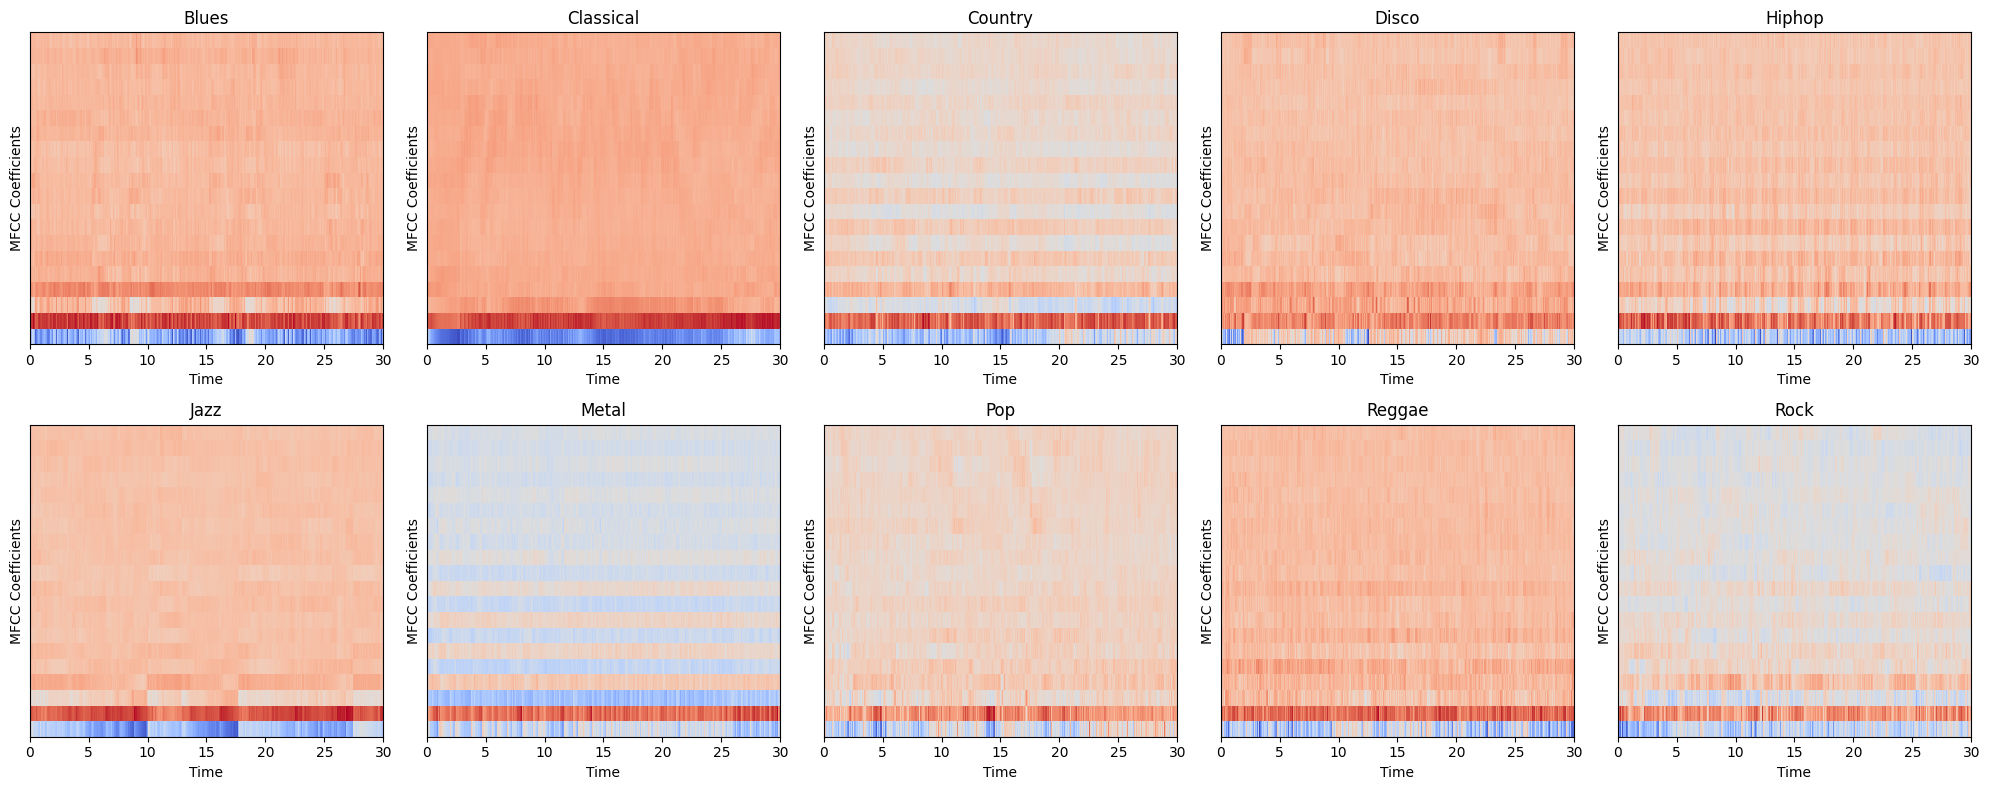

MFCC visualization saved as 'mfcc_samples.png'


In [11]:
# Visualize MFCC for one sample from each genre
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, genre in enumerate(GENRES):
    # Find first sample of this genre
    idx = np.where(y == i)[0][0]

    # Plot MFCC
    img = librosa.display.specshow(X[idx], x_axis='time', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f'{genre.capitalize()}')
    axes[i].set_ylabel('MFCC Coefficients')

plt.tight_layout()
plt.savefig('mfcc_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("MFCC visualization saved as 'mfcc_samples.png'")

## 8. Build Basic VAE Model

In [12]:
# VAE Configuration
LATENT_DIM = 32
INPUT_SHAPE = X_input.shape[1:]  # (n_mfcc, time_steps, 1)

print(f"Input shape: {INPUT_SHAPE}")
print(f"Latent dimension: {LATENT_DIM}")

Input shape: (20, 1293, 1)
Latent dimension: 32


In [13]:
# Sampling layer for VAE
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
# Build Encoder
def build_encoder(input_shape, latent_dim):
    """
    Build encoder network.

    Args:
        input_shape: Shape of input (n_mfcc, time_steps, 1)
        latent_dim: Dimension of latent space

    Returns:
        encoder: Keras Model
    """
    encoder_inputs = keras.Input(shape=input_shape, name='encoder_input')

    x = layers.Flatten()(encoder_inputs)
    x = layers.Dense(512, activation='relu', name='encoder_dense_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu', name='encoder_dense_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu', name='encoder_dense_3')(x)

    # Latent space parameters
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Sample from latent space
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

encoder = build_encoder(INPUT_SHAPE, LATENT_DIM)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 20, 1293,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25860)     │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 512)       │ 13,240,832 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ encoder_dense_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_2     │ (None, 256)       │    131,328 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ encoder_dense_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_3     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │      4,128 │ encoder_dense_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │      4,128 │ encoder_dense_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,416,384 (51.18 MB)

 Trainable params: 13,414,848 (51.17 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [15]:
# Build Decoder
def build_decoder(latent_dim, output_shape):
    """
    Build decoder network.

    Args:
        latent_dim: Dimension of latent space
        output_shape: Shape of output (n_mfcc, time_steps, 1)

    Returns:
        decoder: Keras Model
    """
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')

    x = layers.Dense(128, activation='relu', name='decoder_dense_1')(latent_inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation='relu', name='decoder_dense_2')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(512, activation='relu', name='decoder_dense_3')(x)
    x = layers.BatchNormalization()(x)

    # Output layer
    output_dim = np.prod(output_shape)
    x = layers.Dense(output_dim, activation='linear', name='decoder_output')(x)

    # Reshape to original shape
    decoder_outputs = layers.Reshape(output_shape)(x)

    decoder = Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder

decoder = build_decoder(LATENT_DIM, INPUT_SHAPE)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_3 (Dense)         │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 25860)          │    13,266,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 20, 1293, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,438,596 (51.26 MB)

 Trainable params: 13,436,804 (51.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
# Build VAE - FIXED VERSION
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction), axis=(1, 2, 3)
                )
            )

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Add test step for validation"""
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction), axis=(1, 2, 3)
            )
        )

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        # Total loss
        total_loss = reconstruction_loss + kl_loss

        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# Create VAE model - FIXED COMPILE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

print("✅ VAE model created successfully!")

✅ VAE model created successfully!


## 9. Train VAE

In [17]:
# Training configuration - FIXED VERSION
EPOCHS = 50
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Callbacks - FIXED
early_stopping = keras.callbacks.EarlyStopping(
    monitor='total_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'  # ← ADDED THIS
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='total_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    mode='min'  # ← ADDED THIS
)

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Validation split: {VALIDATION_SPLIT}")

Training configuration:
  Epochs: 50
  Batch size: 32
  Validation split: 0.2


In [18]:
# Train the VAE
history = vae.fit(
    X_input,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✅ Training completed!")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - kl_loss: 40932244.0000 - reconstruction_loss: 27893774.0000 - total_loss: 68826016.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 463ms/step - kl_loss: 393052032.0000 - reconstruction_loss: 42911232.0000 - total_loss: 435963264.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 535ms/step - kl_loss: 189642.0312 - reconstruction_loss: 23415.9316 - total_loss: 213057.9688 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - kl_loss: 150283184.0000 - reconstruction_loss: 56396152.0000 - total_loss: 206679328.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss

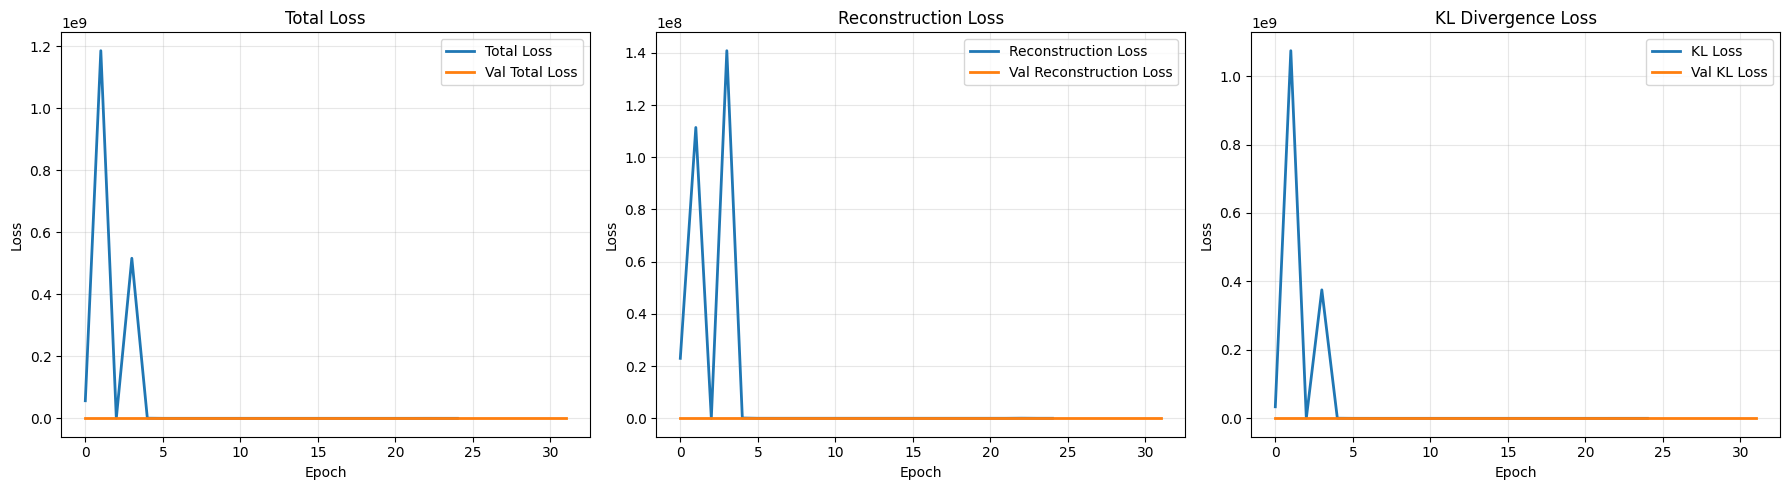

Training history saved as 'training_history.png'


In [19]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total loss
axes[0].plot(history.history['total_loss'], label='Total Loss', linewidth=2)
if 'val_total_loss' in history.history:
    axes[0].plot(history.history['val_total_loss'], label='Val Total Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history.history['reconstruction_loss'], label='Reconstruction Loss', linewidth=2)
if 'val_reconstruction_loss' in history.history:
    axes[1].plot(history.history['val_reconstruction_loss'], label='Val Reconstruction Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL loss
axes[2].plot(history.history['kl_loss'], label='KL Loss', linewidth=2)
if 'val_kl_loss' in history.history:
    axes[2].plot(history.history['val_kl_loss'], label='Val KL Loss', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('KL Divergence Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history saved as 'training_history.png'")

## 10. Extract Latent Features

In [20]:
# Extract latent representations (z_mean) for all samples
z_mean, z_log_var, z = encoder.predict(X_input, batch_size=BATCH_SIZE)

print(f"Latent features shape: {z_mean.shape}")
print(f"Using z_mean for clustering (more stable than sampled z)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Latent features shape: (999, 32)
Using z_mean for clustering (more stable than sampled z)


## 11. Clustering with K-Means

In [21]:
# Number of clusters (same as number of genres)
N_CLUSTERS = len(GENRES)

# K-Means on VAE latent features
kmeans_vae = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
clusters_vae = kmeans_vae.fit_predict(z_mean)

print(f"✅ VAE K-Means clustering completed!")
print(f"Cluster distribution: {np.bincount(clusters_vae)}")

✅ VAE K-Means clustering completed!
Cluster distribution: [109 117  91 182  82 110  43 149  68  48]


## 12. Baseline: PCA + K-Means

In [22]:
# Flatten MFCC features for PCA
X_flat = X_normalized.reshape(len(X_normalized), -1)

# Apply PCA to reduce to same dimension as VAE latent space
pca = PCA(n_components=LATENT_DIM, random_state=42)
X_pca = pca.fit_transform(X_flat)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"PCA features shape: {X_pca.shape}")

PCA explained variance ratio: 0.4523
PCA features shape: (999, 32)


In [23]:
# K-Means on PCA features
kmeans_pca = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)

print(f"✅ PCA K-Means clustering completed!")
print(f"Cluster distribution: {np.bincount(clusters_pca)}")

✅ PCA K-Means clustering completed!
Cluster distribution: [143 104  80 110 126  56 160  81 126  13]


## 13. Evaluation Metrics

In [24]:
# Calculate metrics for VAE clustering
silhouette_vae = silhouette_score(z_mean, clusters_vae)
calinski_vae = calinski_harabasz_score(z_mean, clusters_vae)

# Calculate metrics for PCA clustering
silhouette_pca = silhouette_score(X_pca, clusters_pca)
calinski_pca = calinski_harabasz_score(X_pca, clusters_pca)

# Create results dataframe
results = pd.DataFrame({
    'Method': ['VAE + K-Means', 'PCA + K-Means'],
    'Silhouette Score': [silhouette_vae, silhouette_pca],
    'Calinski-Harabasz Index': [calinski_vae, calinski_pca]
})

print("\n" + "="*60)
print("CLUSTERING EVALUATION METRICS")
print("="*60)
print(results.to_string(index=False))
print("="*60)

# Save results
results.to_csv('clustering_metrics.csv', index=False)
print("\n✅ Results saved to 'clustering_metrics.csv'")


CLUSTERING EVALUATION METRICS
       Method  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          0.166369               124.919807
PCA + K-Means          0.092701               135.352463

✅ Results saved to 'clustering_metrics.csv'


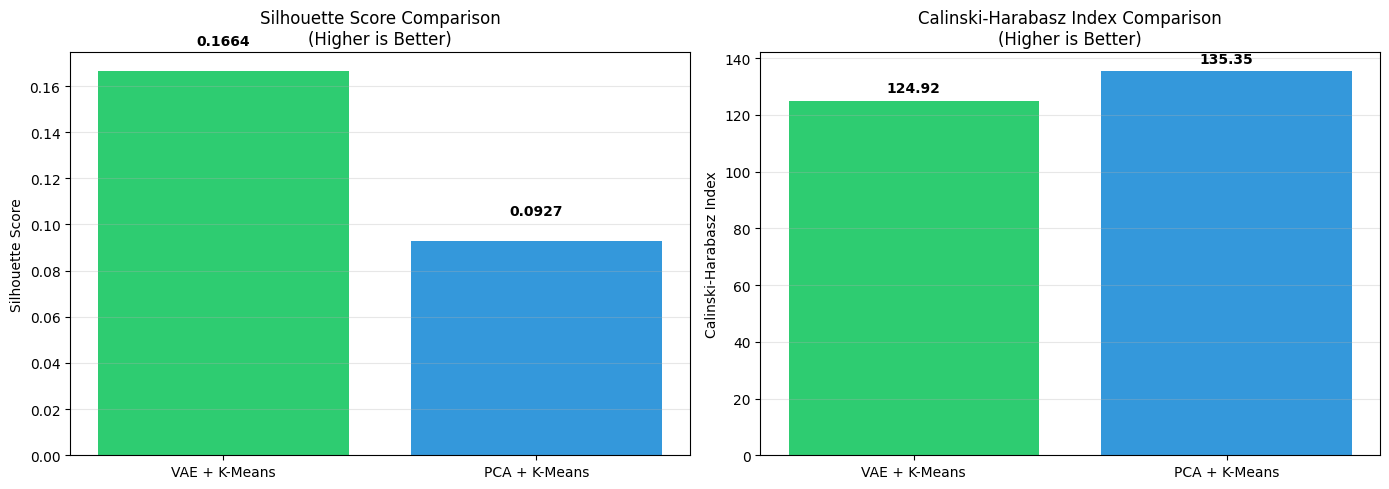

Metrics comparison saved as 'metrics_comparison.png'


In [25]:
# Visualize metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette Score
axes[0].bar(['VAE + K-Means', 'PCA + K-Means'],
            [silhouette_vae, silhouette_pca],
            color=['#2ecc71', '#3498db'])
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score Comparison\n(Higher is Better)')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([silhouette_vae, silhouette_pca]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Calinski-Harabasz Index
axes[1].bar(['VAE + K-Means', 'PCA + K-Means'],
            [calinski_vae, calinski_pca],
            color=['#2ecc71', '#3498db'])
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index Comparison\n(Higher is Better)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([calinski_vae, calinski_pca]):
    axes[1].text(i, v + 2, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Metrics comparison saved as 'metrics_comparison.png'")

## 14. Visualization: t-SNE

In [26]:
# Apply t-SNE to VAE latent features
print("Applying t-SNE to VAE latent features...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
z_tsne = tsne.fit_transform(z_mean)

# Apply t-SNE to PCA features
print("Applying t-SNE to PCA features...")
tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30)
pca_tsne = tsne_pca.fit_transform(X_pca)

print("✅ t-SNE completed!")

Applying t-SNE to VAE latent features...
Applying t-SNE to PCA features...
✅ t-SNE completed!


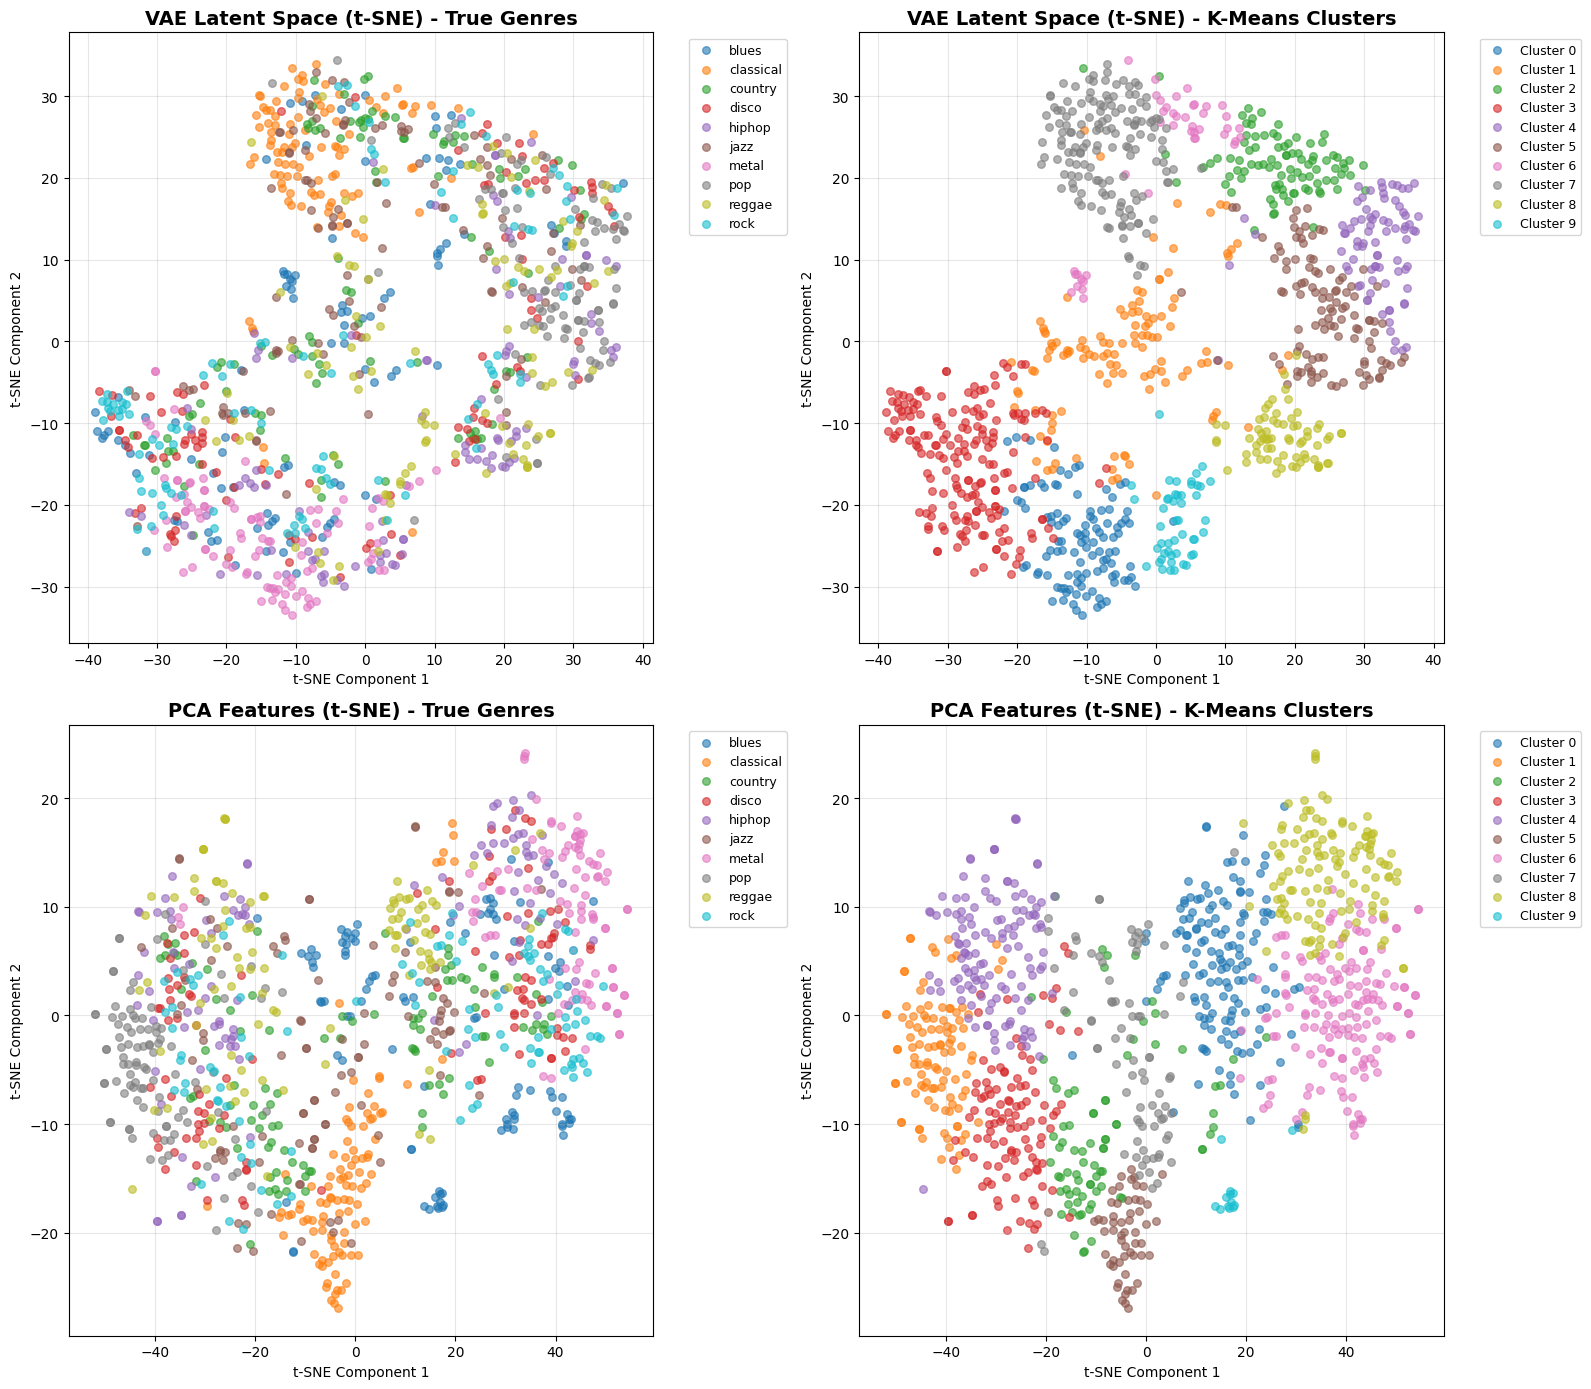

t-SNE visualization saved as 'tsne_visualization.png'


In [27]:
# Visualize t-SNE results
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Color maps
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# VAE - Colored by true genre
for i, genre in enumerate(GENRES):
    mask = y == i
    axes[0, 0].scatter(z_tsne[mask, 0], z_tsne[mask, 1],
                      c=[colors[i]], label=genre, alpha=0.6, s=30)
axes[0, 0].set_title('VAE Latent Space (t-SNE) - True Genres', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('t-SNE Component 1')
axes[0, 0].set_ylabel('t-SNE Component 2')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# VAE - Colored by predicted cluster
for i in range(N_CLUSTERS):
    mask = clusters_vae == i
    axes[0, 1].scatter(z_tsne[mask, 0], z_tsne[mask, 1],
                      c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[0, 1].set_title('VAE Latent Space (t-SNE) - K-Means Clusters', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('t-SNE Component 1')
axes[0, 1].set_ylabel('t-SNE Component 2')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# PCA - Colored by true genre
for i, genre in enumerate(GENRES):
    mask = y == i
    axes[1, 0].scatter(pca_tsne[mask, 0], pca_tsne[mask, 1],
                      c=[colors[i]], label=genre, alpha=0.6, s=30)
axes[1, 0].set_title('PCA Features (t-SNE) - True Genres', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('t-SNE Component 1')
axes[1, 0].set_ylabel('t-SNE Component 2')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# PCA - Colored by predicted cluster
for i in range(N_CLUSTERS):
    mask = clusters_pca == i
    axes[1, 1].scatter(pca_tsne[mask, 0], pca_tsne[mask, 1],
                      c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[1, 1].set_title('PCA Features (t-SNE) - K-Means Clusters', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('t-SNE Component 1')
axes[1, 1].set_ylabel('t-SNE Component 2')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("t-SNE visualization saved as 'tsne_visualization.png'")

## 15. Visualization: UMAP

In [28]:
# Apply UMAP to VAE latent features
print("Applying UMAP to VAE latent features...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
z_umap = umap_reducer.fit_transform(z_mean)

# Apply UMAP to PCA features
print("Applying UMAP to PCA features...")
umap_pca_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
pca_umap = umap_pca_reducer.fit_transform(X_pca)

print("✅ UMAP completed!")

Applying UMAP to VAE latent features...
Applying UMAP to PCA features...
✅ UMAP completed!


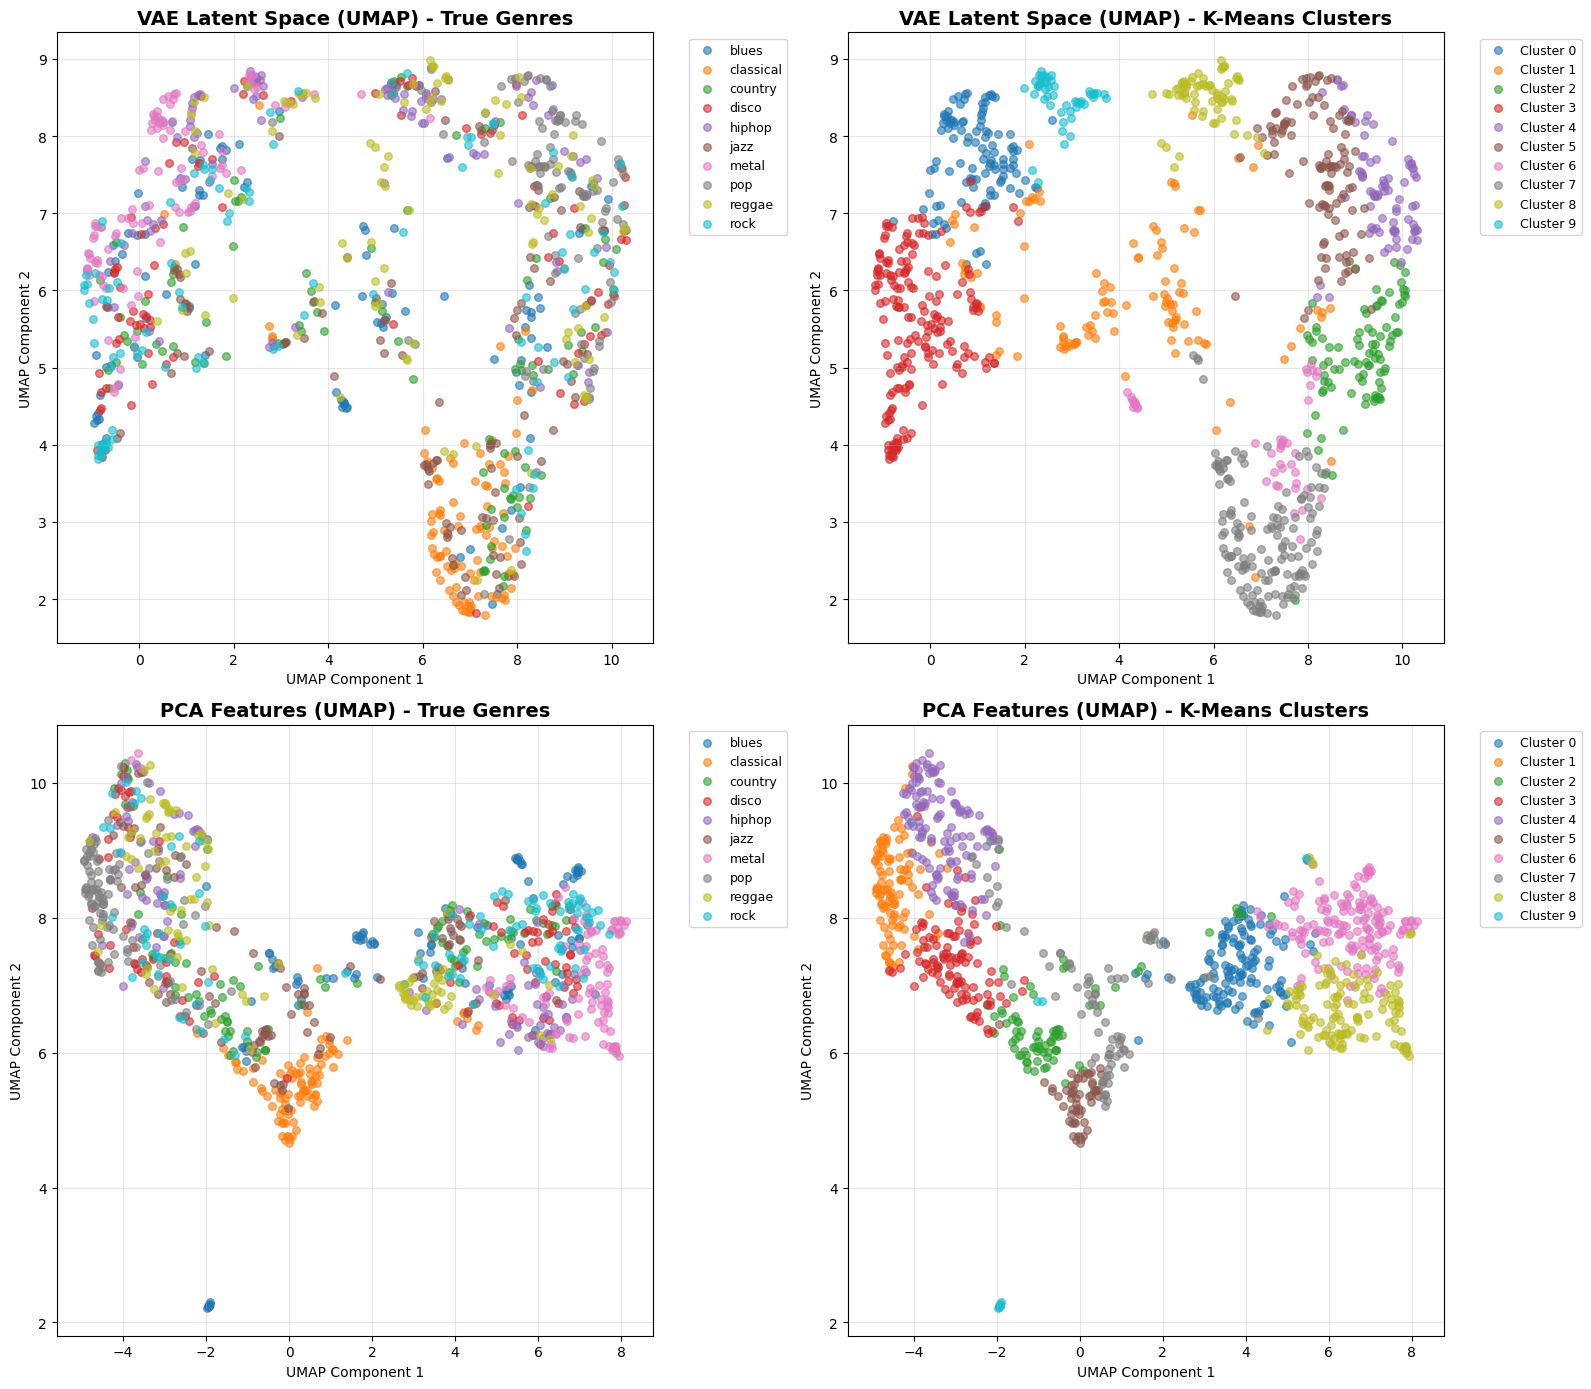

UMAP visualization saved as 'umap_visualization.png'


In [29]:
# Visualize UMAP results
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# VAE - Colored by true genre
for i, genre in enumerate(GENRES):
    mask = y == i
    axes[0, 0].scatter(z_umap[mask, 0], z_umap[mask, 1],
                      c=[colors[i]], label=genre, alpha=0.6, s=30)
axes[0, 0].set_title('VAE Latent Space (UMAP) - True Genres', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('UMAP Component 1')
axes[0, 0].set_ylabel('UMAP Component 2')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# VAE - Colored by predicted cluster
for i in range(N_CLUSTERS):
    mask = clusters_vae == i
    axes[0, 1].scatter(z_umap[mask, 0], z_umap[mask, 1],
                      c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[0, 1].set_title('VAE Latent Space (UMAP) - K-Means Clusters', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('UMAP Component 1')
axes[0, 1].set_ylabel('UMAP Component 2')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# PCA - Colored by true genre
for i, genre in enumerate(GENRES):
    mask = y == i
    axes[1, 0].scatter(pca_umap[mask, 0], pca_umap[mask, 1],
                      c=[colors[i]], label=genre, alpha=0.6, s=30)
axes[1, 0].set_title('PCA Features (UMAP) - True Genres', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('UMAP Component 1')
axes[1, 0].set_ylabel('UMAP Component 2')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# PCA - Colored by predicted cluster
for i in range(N_CLUSTERS):
    mask = clusters_pca == i
    axes[1, 1].scatter(pca_umap[mask, 0], pca_umap[mask, 1],
                      c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[1, 1].set_title('PCA Features (UMAP) - K-Means Clusters', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('UMAP Component 1')
axes[1, 1].set_ylabel('UMAP Component 2')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('umap_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("UMAP visualization saved as 'umap_visualization.png'")

## 16. Reconstruction Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


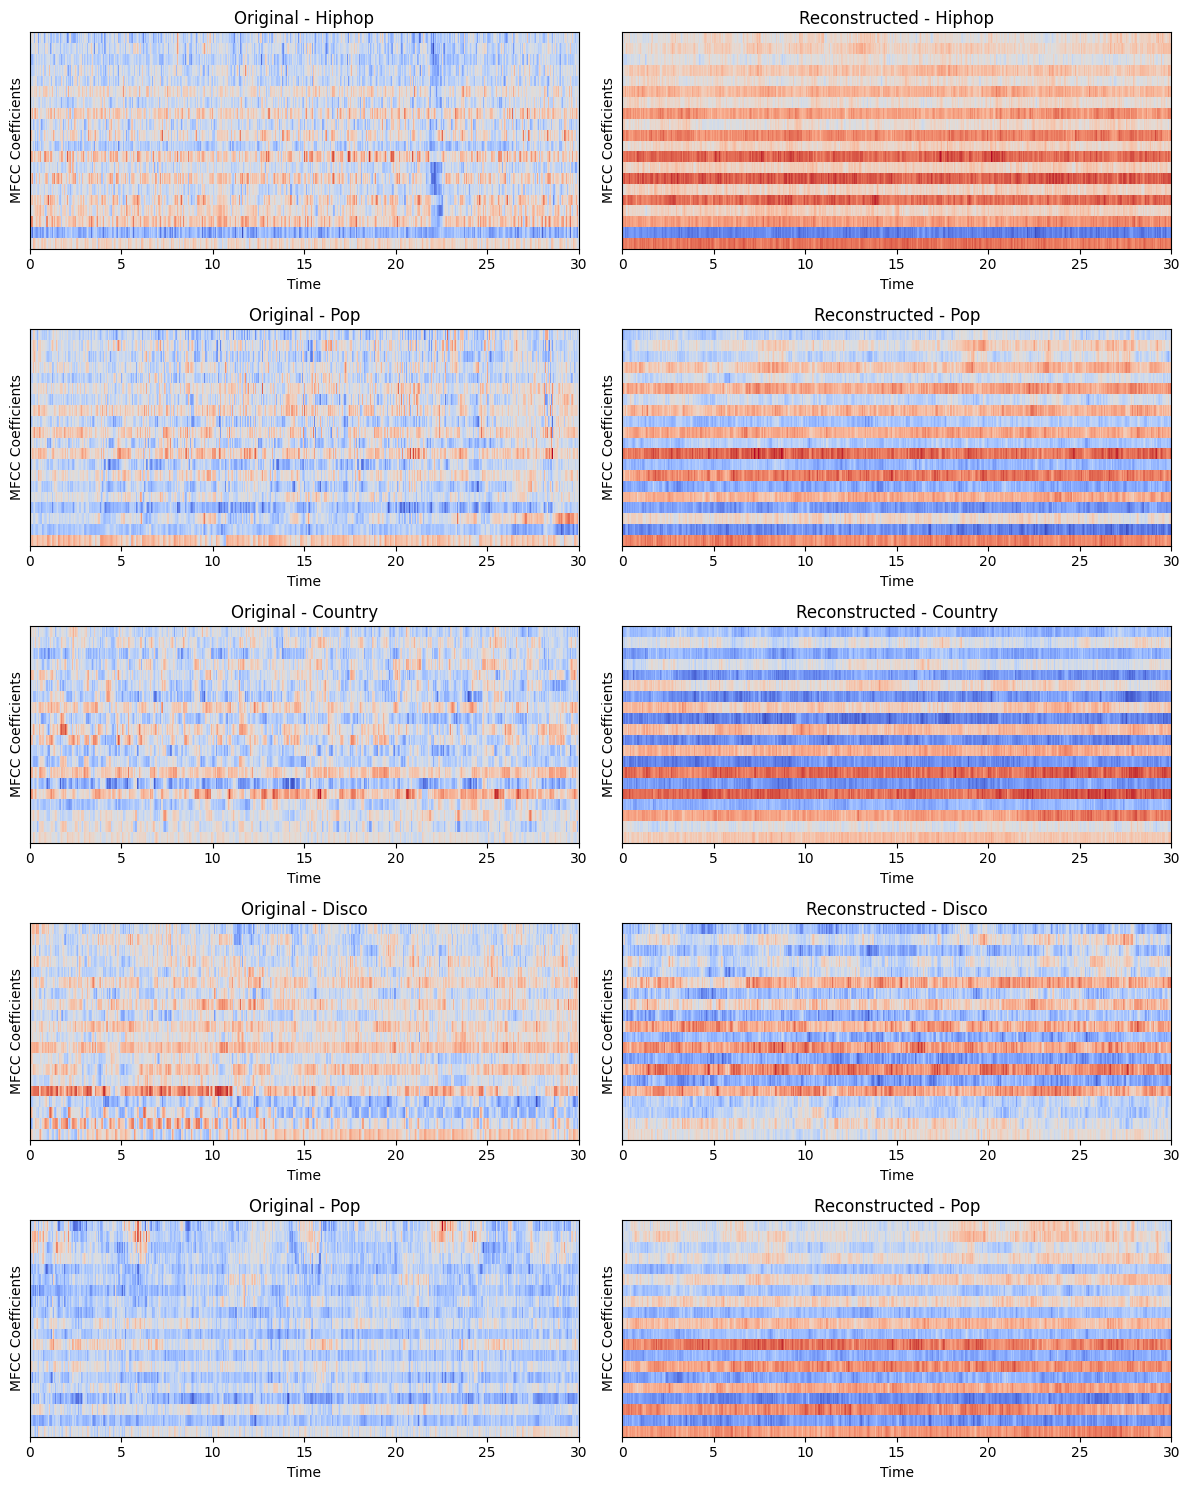

VAE reconstructions saved as 'vae_reconstructions.png'


In [30]:
# Reconstruct samples from VAE
n_samples = 5
sample_indices = np.random.choice(len(X_input), n_samples, replace=False)

reconstructions = vae.predict(X_input[sample_indices])

# Visualize original vs reconstructed
fig, axes = plt.subplots(n_samples, 2, figsize=(12, 3 * n_samples))

for i, idx in enumerate(sample_indices):
    # Original
    librosa.display.specshow(X_normalized[idx], x_axis='time', ax=axes[i, 0], cmap='coolwarm')
    axes[i, 0].set_title(f'Original - {GENRES[y[idx]].capitalize()}')
    axes[i, 0].set_ylabel('MFCC Coefficients')

    # Reconstructed
    librosa.display.specshow(reconstructions[i, :, :, 0], x_axis='time', ax=axes[i, 1], cmap='coolwarm')
    axes[i, 1].set_title(f'Reconstructed - {GENRES[y[idx]].capitalize()}')
    axes[i, 1].set_ylabel('MFCC Coefficients')

plt.tight_layout()
plt.savefig('vae_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

print("VAE reconstructions saved as 'vae_reconstructions.png'")

## 17. Summary and Conclusions

In [31]:
print("\n" + "="*80)
print("EASY TASK SUMMARY")
print("="*80)

print("\n1. Dataset:")
print(f"   - Source: Kaggle GTZAN Dataset")
print(f"   - Total samples: {len(X)}")
print(f"   - Genres: {', '.join(GENRES)}")
print(f"   - Feature extraction: MFCC ({N_MFCC} coefficients)")

print("\n2. VAE Architecture:")
print(f"   - Input shape: {INPUT_SHAPE}")
print(f"   - Latent dimension: {LATENT_DIM}")
print(f"   - Encoder: Dense layers (512 -> 256 -> 128 -> {LATENT_DIM})")
print(f"   - Decoder: Dense layers ({LATENT_DIM} -> 128 -> 256 -> 512 -> Output)")

print("\n3. Clustering Results:")
print(f"   - Number of clusters: {N_CLUSTERS}")
print(f"   - Algorithm: K-Means")

print("\n4. Evaluation Metrics:")
print(f"\n   VAE + K-Means:")
print(f"   - Silhouette Score: {silhouette_vae:.4f}")
print(f"   - Calinski-Harabasz Index: {calinski_vae:.2f}")

print(f"\n   PCA + K-Means (Baseline):")
print(f"   - Silhouette Score: {silhouette_pca:.4f}")
print(f"   - Calinski-Harabasz Index: {calinski_pca:.2f}")

print("\n5. Visualizations Generated:")
print("   ✓ MFCC samples")
print("   ✓ Training history")
print("   ✓ Metrics comparison")
print("   ✓ t-SNE visualization")
print("   ✓ UMAP visualization")
print("   ✓ VAE reconstructions")

print("\n6. Key Findings:")
if silhouette_vae > silhouette_pca:
    print("   ✓ VAE latent features produce better clusters than PCA (higher Silhouette Score)")
else:
    print("   • PCA baseline performs better than VAE on Silhouette Score")

if calinski_vae > calinski_pca:
    print("   ✓ VAE shows better cluster separation (higher Calinski-Harabasz Index)")
else:
    print("   • PCA baseline shows better cluster separation on Calinski-Harabasz Index")

print("\n" + "="*80)
print("EASY TASK COMPLETED SUCCESSFULLY!")
print("="*80 + "\n")


EASY TASK SUMMARY

1. Dataset:
   - Source: Kaggle GTZAN Dataset
   - Total samples: 999
   - Genres: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
   - Feature extraction: MFCC (20 coefficients)

2. VAE Architecture:
   - Input shape: (20, 1293, 1)
   - Latent dimension: 32
   - Encoder: Dense layers (512 -> 256 -> 128 -> 32)
   - Decoder: Dense layers (32 -> 128 -> 256 -> 512 -> Output)

3. Clustering Results:
   - Number of clusters: 10
   - Algorithm: K-Means

4. Evaluation Metrics:

   VAE + K-Means:
   - Silhouette Score: 0.1664
   - Calinski-Harabasz Index: 124.92

   PCA + K-Means (Baseline):
   - Silhouette Score: 0.0927
   - Calinski-Harabasz Index: 135.35

5. Visualizations Generated:
   ✓ MFCC samples
   ✓ Training history
   ✓ Metrics comparison
   ✓ t-SNE visualization
   ✓ UMAP visualization
   ✓ VAE reconstructions

6. Key Findings:
   ✓ VAE latent features produce better clusters than PCA (higher Silhouette Score)
   • PCA baseline shows bet

## 18. Save Models and Data

In [32]:
# Save VAE model
vae.save('vae_model.keras')
encoder.save('encoder_model.keras')
decoder.save('decoder_model.keras')

# Save latent features and clusters
np.save('vae_latent_features.npy', z_mean)
np.save('pca_features.npy', X_pca)
np.save('vae_clusters.npy', clusters_vae)
np.save('pca_clusters.npy', clusters_pca)
np.save('true_labels.npy', y)

print("✅ Models and data saved successfully!")
print("\nSaved files:")
print("  - vae_model.keras")
print("  - encoder_model.keras")
print("  - decoder_model.keras")
print("  - vae_latent_features.npy")
print("  - pca_features.npy")
print("  - vae_clusters.npy")
print("  - pca_clusters.npy")
print("  - true_labels.npy")

✅ Models and data saved successfully!

Saved files:
  - vae_model.keras
  - encoder_model.keras
  - decoder_model.keras
  - vae_latent_features.npy
  - pca_features.npy
  - vae_clusters.npy
  - pca_clusters.npy
  - true_labels.npy


## 19. Download Results

In [1]:
# Create a zip file with all results
import zipfile

files_to_zip = [
    'clustering_metrics.csv',
    'mfcc_samples.png',
    'training_history.png',
    'metrics_comparison.png',
    'tsne_visualization.png',
    'umap_visualization.png',
    'vae_reconstructions.png',
    'vae_latent_features.npy',
    'pca_features.npy',
    'vae_clusters.npy',
    'pca_clusters.npy',
    'true_labels.npy'
]

with zipfile.ZipFile('easy_task_results.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)

print("✅ Results packaged in 'easy_task_results.zip'")
print("\nYou can download this file from Colab's file browser (left sidebar).")


NameError: name 'os' is not defined